# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Importing Libraries

In [ ]:
##Importing Libraries
from pylab import imshow, show
import glob 
import time
import os
import logging
import nibabel as nb
import numpy as np
import random as random
from PIL import Image
from matplotlib import cm
from matplotlib import pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import nn
from torch.optim import Adam
import torch
import cv2
from torchvision import models
import torchvision
!pip install mahotas
import mahotas
from torch.nn import functional as F
from scipy import ndimage
from torchvision import transforms
!pip install tensorboardX
from tensorboardX import SummaryWriter
plt.style.use("dark_background")
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Data Preprocessing

In [ ]:
IMG_PATH ='/content/gdrive/MyDrive/ISBD/'
# CARE10 image labels missing so CARE10 train image removed
train_images = []
train_labels = []
images_path = glob.glob(os.path.join(IMG_PATH,'train_images/','*'))
labels_path = glob.glob(os.path.join(IMG_PATH,'train_labels/','*'))

In [ ]:
img = nb.load(images_path[0]).get_fdata()
for i in range(len(images_path)):
  for j in range(img.shape[0]):
    im = Image.fromarray(nb.load(images_path[i]).get_fdata()[j,:,:]).convert('RGB')
    im.save("/content/gdrive/MyDrive/Train_images/"+str(i)+"_"+str(j)+".jpeg","Jpeg")

In [ ]:
# def ImagetoMask(image):
#     mask = Image.fromarray(np.uint8(cm.gist_earth(image)*255)).convert('RGB')
#     mask = np.asarray(mask)
#     return mask
# def MasktoContour(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     mask = Image.fromarray(np.uint8(cm.gist_earth(gray)*255))
#     edged = cv2.Canny(gray, 30, 200)
#     contours, hierarchy = cv2.findContours(edged,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
#     contour_img = cv2.drawContours(image, contours, -1, (0, 255, 0), 1)
#     return contour_img
# def ContourtoDistanceMap(image):
#     gaussian = mahotas.gaussian_filter(image, 15)
#     gaussian = (gaussian > gaussian.mean())
#     labeled, n_nucleus = mahotas.label(gaussian)
#     dmap = mahotas.distance(labeled)
#     return dmap

In [ ]:
img = nb.load(images_path[0]).get_fdata()
size = img.shape[0]
for i in range(len(images_path)):
  for j in range(size):
    img = Image.fromarray(((nb.load(labels_path[i]).get_fdata()==2).astype(int)*255).astype(np.uint8)[j,:,:]).convert('L')
    img.save("/content/gdrive/MyDrive/Train_Labels/Masks/"+str(i)+"_"+str(j)+".jpeg","Jpeg")
    gaussian = mahotas.gaussian_filter(img,0.625)
    gaussian = (gaussian > gaussian.mean())
    labelled, n_nucleus = mahotas.label(gaussian)
    relabeled = mahotas.labeled.bwperim(labelled, 8)
    im = Image.fromarray(relabeled)
    im.save("/content/gdrive/MyDrive/Train_Labels/Contours/"+str(i)+"_"+str(j)+".jpeg","Jpeg")
    dmap = mahotas.distance(labelled)
    plt.imsave("/content/gdrive/MyDrive/Train_Labels/Distance_Maps/"+str(i)+"_"+str(j)+".jpeg",dmap)

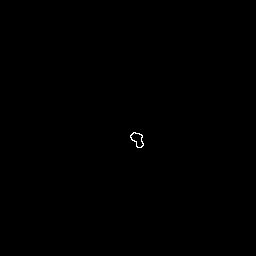

In [ ]:
# # for i in range(len(labels_path)):
# #   for j in range(img.shape[0]):
# img = Image.fromarray(((nb.load(labels_path[6]).get_fdata()==2).astype(int)*255).astype(np.uint8)[91,:,:]).convert('L')
# ims = ((nb.load(labels_path[6]).get_fdata()==2).astype(int)*255).astype(np.uint8)[91,:,:]
# gaussian = mahotas.gaussian_filter(img,0.625)
# gaussian = (gaussian > gaussian.mean())
# labelled, n_nucleus = mahotas.label(gaussian)
# relabeled = mahotas.labeled.bwperim(labelled, 8)
# im = Image.fromarray(relabeled)
# im
# dmap = mahotas.distance(labelled)
# plt.imsave("/content/gdrive/MyDrive/Train_Labels/Distance_Maps/test.jpeg",dmap)

# Model

In [ ]:
PATH = "/content/gdrive/MyDrive/"
train_images = []
label_masks = []
label_distance = []
label_contour = []
train_images = glob.glob(os.path.join(PATH,'Train_images','*'))
# label_masks = glob.glob(os.path.join(PATH,'Train_Labels/Masks','*'))
# label_distance = glob.glob(os.path.join(PATH,'Train_Labels/Distance_Maps','*'))
# label_contour = glob.glob(os.path.join(PATH,'Train_Labels/Contours','*'))

In [ ]:
print(len(train_images))
print(len(label_masks))
print(len(label_distance))
print(len(label_contour))

21696
21696
21696
21696


In [ ]:
class DatasetImageMaskContourDist(Dataset):

    def __init__(self, train_images):

        self.train_images = train_images

    def __len__(self):

        return len(self.train_images)

    def __getitem__(self, idx):

        img_file_name = self.train_images[idx]
        image = load_image(img_file_name)
        mask = load_mask(img_file_name)
        contour = load_contour(img_file_name)
        dist = load_distance(img_file_name)

        return img_file_name, image, mask, contour, dist


def load_image(path):

    img = Image.open(path)
    data_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    img = data_transforms(img)
    # print(img.shape)
    # img = img[0]

    return img


def load_mask(path):

    mask = cv2.imread(path.replace("Train_images", "Train_Labels/Masks"), 0)
    mask[mask == 255] = 1

    return torch.from_numpy(np.expand_dims(mask, 0)).long()


def load_contour(path):

    contour = cv2.imread(path.replace("Train_images", "Train_Labels/Contours"), 0)
    contour[contour == 255] = 1

    return torch.from_numpy(np.expand_dims(contour, 0)).long()


def load_distance(path):

    dist = cv2.imread(path.replace("Train_images", "Train_Labels/Distance_Maps"),0)

    return torch.from_numpy(np.expand_dims(dist, 0)).float()

In [ ]:
train, validate, test = np.split(train_images, [int(.6*len(train_images)), int(.8*len(train_images))])

In [ ]:
def conv3x3(in_, out):
    return nn.Conv2d(in_, out, 3, padding=1)

In [ ]:
class Conv3BN(nn.Module):
    def __init__(self, in_: int, out: int, bn=False):
        super().__init__()
        self.conv = conv3x3(in_, out)
        self.bn = nn.BatchNorm2d(out) if bn else None
        self.activation = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        x = self.activation(x)
        return x

In [ ]:
class UNetModule(nn.Module):
    def __init__(self, in_: int, out: int):
        super().__init__()
        self.l1 = Conv3BN(in_, out)
        self.l2 = Conv3BN(out, out)

    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        return

In [ ]:
class PsiNet(nn.Module):
    output_downscaled = 1
    module = UNetModule

    def __init__(
        self,
        input_channels: int = 3,
        filters_base: int = 32,
        down_filter_factors=(1, 2, 4, 8, 16),
        up_filter_factors=(1, 2, 4, 8, 16),
        bottom_s=4,
        num_classes=1,
        add_output=True,
    ):
        super().__init__()
        self.num_classes = num_classes
        assert len(down_filter_factors) == len(up_filter_factors)
        assert down_filter_factors[-1] == up_filter_factors[-1]
        down_filter_sizes = [filters_base * s for s in down_filter_factors]
        up_filter_sizes = [filters_base * s for s in up_filter_factors]
        self.down, self.up = nn.ModuleList(), nn.ModuleList()
        self.down.append(self.module(input_channels, down_filter_sizes[0]))
        for prev_i, nf in enumerate(down_filter_sizes[1:]):
            self.down.append(self.module(down_filter_sizes[prev_i], nf))
        for prev_i, nf in enumerate(up_filter_sizes[1:]):
            self.up.append(
                self.module(down_filter_sizes[prev_i] + nf, up_filter_sizes[prev_i])
            )
        pool = nn.MaxPool2d(2, 2)
        pool_bottom = nn.MaxPool2d(bottom_s, bottom_s)
        upsample1 = nn.Upsample(scale_factor=2)
        upsample_bottom1 = nn.Upsample(scale_factor=bottom_s)
        upsample2 = nn.Upsample(scale_factor=2)
        upsample_bottom2 = nn.Upsample(scale_factor=bottom_s)
        upsample3 = nn.Upsample(scale_factor=2)
        upsample_bottom3 = nn.Upsample(scale_factor=bottom_s)

        self.downsamplers = [None] + [pool] * (len(self.down) - 1)
        self.downsamplers[-1] = pool_bottom
        self.upsamplers1 = [upsample1] * len(self.up)
        self.upsamplers1[-1] = upsample_bottom1
        self.upsamplers2 = [upsample2] * len(self.up)
        self.upsamplers2[-1] = upsample_bottom2
        self.upsamplers3 = [upsample3] * len(self.up)
        self.upsamplers3[-1] = upsample_bottom3

        self.add_output = add_output
        if add_output:
            self.conv_final1 = nn.Conv2d(up_filter_sizes[0], num_classes, 1)
        if add_output:
            self.conv_final2 = nn.Conv2d(up_filter_sizes[0], num_classes, 1)
        if add_output:
            self.conv_final3 = nn.Conv2d(up_filter_sizes[0], 1, 1)

    def forward(self, x):
        xs = []
        print(len(self.downsamplers),len(self.down))
        for downsample, down in zip(self.downsamplers, self.down):
            print("x:",x.shape)
            x_in = x if downsample is None else downsample(xs[-1])
            x_out = down(x_in)  #fix this one
            print(x_out)
            xs.append(x_out)
            print(xs)

        x_out = xs[-1]
        x_out1 = x_out
        x_out2 = x_out
        x_out3 = x_out

        # Decoder mask segmentation
        for x_skip, upsample, up in reversed(
            list(zip(xs[:-1], self.upsamplers1, self.up))
        ):
            x_out1 = upsample(x_out1)
            x_out1 = up(torch.cat([x_out1, x_skip], 1))

        # Decoder contour estimation
        for x_skip, upsample, up in reversed(
            list(zip(xs[:-1], self.upsamplers2, self.up))
        ):
            x_out2 = upsample(x_out2)
            x_out2 = up(torch.cat([x_out2, x_skip], 1))

        # Regression
        for x_skip, upsample, up in reversed(
            list(zip(xs[:-1], self.upsamplers3, self.up))
        ):
            x_out3 = upsample(x_out3)
            x_out3 = up(torch.cat([x_out3, x_skip], 1))

        if self.add_output:
            x_out1 = self.conv_final1(x_out1)
            if self.num_classes > 1:
                x_out1 = F.log_softmax(x_out1, dim=1)

        if self.add_output:
            x_out2 = self.conv_final2(x_out2)
            if self.num_classes > 1:
                x_out2 = F.log_softmax(x_out2, dim=1)

        if self.add_output:
            x_out3 = self.conv_final3(x_out3)
            x_out3 = F.sigmoid(x_out3)

        return [x_out1, x_out2, x_out3]

In [ ]:
class LossMulti:
    def __init__(
        self, jaccard_weight=0, class_weights=None, num_classes=2, device=None
    ):
        self.device = device
        if class_weights is not None:
            nll_weight = torch.from_numpy(class_weights.astype(np.float32)).to(
                self.device
            )
        else:
            nll_weight = None

        self.nll_loss = nn.NLLLoss(weight=nll_weight)
        self.jaccard_weight = jaccard_weight
        self.num_classes = num_classes

    def __call__(self, outputs, targets):

        targets = targets.squeeze(1)
        loss = (1 - self.jaccard_weight) * self.nll_loss(outputs, targets)
        if self.jaccard_weight:
            eps = 1e-7
            for cls in range(self.num_classes):
                jaccard_target = (targets == cls).float()
                jaccard_output = outputs[:, cls].exp()
                intersection = (jaccard_output * jaccard_target).sum()

                union = jaccard_output.sum() + jaccard_target.sum()
                loss -= (
                    torch.log((intersection + eps) / (union - intersection + eps))
                    * self.jaccard_weight
                )

        return loss
class LossPsiNet:
    def __init__(self, weights=[1, 1, 1]):

        self.criterion1 = LossMulti(num_classes=2)
        self.criterion2 = LossMulti(num_classes=2)
        self.criterion3 = nn.MSELoss()
        self.weights = weights

    def __call__(self, outputs1, outputs2, outputs3, targets1, targets2, targets3):

        criterion = (
            self.weights[0] * self.criterion1(outputs1, targets1)
            + self.weights[1] * self.criterion2(outputs2, targets2)
            + self.weights[2] * self.criterion3(outputs3, targets3)
        )

        return criterion

In [ ]:
def build_model():
    model = PsiNet(num_classes=2)
    return model

def train_model(model, targets, criterion, optimizer):

    optimizer.zero_grad()

    with torch.set_grad_enabled(True):
        outputs = model(inputs)
        loss = criterion(
            outputs[0], targets[0]
        )
        loss.backward()
        optimizer.step()
    return loss

def define_loss(weights=[1, 1, 1]):

    criterion = LossPsiNet(weights)

    return criterion

In [ ]:
def evaluate(device, epoch, model, data_loader, writer):
    model.eval()
    losses = []
    start = time.perf_counter()
    with torch.no_grad():

        for iter, data in enumerate(tqdm(data_loader)):

            _, inputs, targets, _, _ = data
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)

            loss = F.nll_loss(outputs[0], targets.squeeze(1))
            losses.append(loss.item())

        writer.add_scalar("Dev_Loss", np.mean(losses), epoch)

    return np.mean(losses), time.perf_counter() - start


def visualize(device, epoch, model, data_loader, writer, val_batch_size, train=False):
    def save_image(image, tag, val_batch_size):
        image -= image.min()
        image /= image.max()
        grid = torchvision.utils.make_grid(
            image, nrow=int(np.sqrt(val_batch_size)), pad_value=0, padding=25
        )
        writer.add_image(tag, grid, epoch)

    model.eval()
    with torch.no_grad():
        for iter, data in enumerate(tqdm(data_loader)):
            _, inputs, targets, _, _ = data

            inputs = inputs.to(device)

            targets = targets.to(device)
            outputs = model(inputs)

            output_mask = outputs[0].detach().cpu().numpy()
            output_final = np.argmax(output_mask, axis=1).astype(float)

            output_final = torch.from_numpy(output_final).unsqueeze(1)

            if train == "True":
                save_image(targets.float(), "Target_train", val_batch_size)
                save_image(output_final, "Prediction_train", val_batch_size)
            else:
                save_image(targets.float(), "Target", val_batch_size)
                save_image(output_final, "Prediction", val_batch_size)

            break

In [ ]:
if __name__ == "__main__":

    log_path = PATH + "/summary"
    writer = SummaryWriter(log_dir=log_path)

    logging.basicConfig(
        filename="".format("brain"),
        filemode="a",
        format="%(asctime)s,%(msecs)d %(name)s %(levelname)s %(message)s",
        datefmt="%Y-%m-%d %H:%M",
        level=logging.INFO,
    )
    logging.info("")

    random.shuffle(train)

    device = torch.device("cpu")

    model = build_model()

    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(device)

    # To handle epoch start number and pretrained weight
    epoch_start = "0"
    # if args.use_pretrained:
    #     print("Loading Model {}".format(os.path.basename(args.pretrained_model_path)))
    #     model.load_state_dict(torch.load(args.pretrained_model_path))
    #     epoch_start = os.path.basename(args.pretrained_model_path).split(".")[0]
    #     print(epoch_start)

    trainLoader = DataLoader(
        DatasetImageMaskContourDist(train),
        batch_size=4,
    )
    devLoader = DataLoader(
        DatasetImageMaskContourDist(validate)
    )
    displayLoader = DataLoader(
        DatasetImageMaskContourDist(validate),
        batch_size=4,
    )

    optimizer = Adam(model.parameters(), lr=1e-4)
    criterion = define_loss()

    num_epochs = 1

    for epoch in tqdm(
        range(int(epoch_start) + 1, int(epoch_start) + 1 + num_epochs)
    ):

        global_step = epoch * len(trainLoader)
        running_loss = 0.0

        for i, (img_file_name, inputs, targets1, targets2, targets3) in enumerate(
            tqdm(trainLoader)
        ):

            model.train()

            inputs = inputs.to(device)
            targets1 = targets1.to(device)
            targets2 = targets2.to(device)
            targets3 = targets3.to(device)

            targets = [targets1, targets2, targets3]

            loss = train_model(model, targets , criterion, optimizer)

            writer.add_scalar("loss", loss.item(), epoch)

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train)

        if epoch % 1 == 0:

            dev_loss, dev_time = evaluate(device, epoch, model, devLoader, writer)
            writer.add_scalar("loss_valid", dev_loss, epoch)
            visualize(device, epoch, model, displayLoader, writer, 4)
            print("Global Loss:{} Val Loss:{}".format(epoch_loss, dev_loss))
        else:
            print("Global Loss:{} ".format(epoch_loss))

        logging.info("epoch:{} train_loss:{} ".format(epoch, epoch_loss))
        if epoch % 5 == 0:
            torch.save(
                model.state_dict(), os.path.join("", str(epoch) + ".pt")
            )

2022-07-04 22:19,922 root INFO 
  0%|          | 0/1 [00:02<?, ?it/s]

5 5
x: torch.Size([4, 3, 256, 256])
None
[None]
x: torch.Size([4, 3, 256, 256])


TypeError: ignored